# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
df.shape

(45993, 3)

In [4]:
df_content.shape

(1056, 5)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
df.isna().sum()

article_id     0
title          0
email         17
dtype: int64

In [6]:
# Including repeated interactions with the same articles and not removing NaN rows in column 'email'
df[['email','article_id']].groupby(['email']).count().describe()

,article_id
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


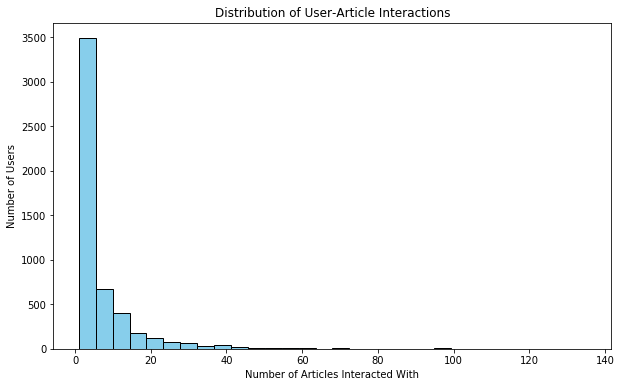

Descriptive Statistics for User-Article Interactions:
count    5148.000000
mean        6.540210
std         9.990676
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       135.000000
Name: article_id, dtype: float64


In [7]:
# Exclude rows with NaN values in the 'email' column before analysis
df_cleaned = df.dropna(subset=['email'])

# Analysis: Counting the number of articles each user interacts with
user_article_counts = df_cleaned.groupby('email')['article_id'].nunique()

# Generating descriptive statistics
descriptive_stats = user_article_counts.describe()

# Visualizing the distribution of user-article interactions
plt.figure(figsize=(10, 6))
user_article_counts.hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of User-Article Interactions')
plt.xlabel('Number of Articles Interacted With')
plt.ylabel('Number of Users')
plt.grid(False)  # Cleaner look without gridlines
plt.show()

# Display descriptive statistics
print("Descriptive Statistics for User-Article Interactions:")
print(descriptive_stats)

In [8]:
median = user_article_counts.median()
median

3.0

In [9]:
# Count the number of interactions per user and find the maximum
max_interactions_by_user = df['email'].value_counts().max()
max_interactions_by_user

364

In [10]:
# Fill in the median and maximum number of user_article interactios below

median_val = median # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = max_interactions_by_user# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
# Find and explore duplicate articles


# Explore duplicates in 'article_id'
duplicate_articles = df_content[df_content.duplicated(subset='article_id', keep=False)]

# Display duplicate 'article_id' entries
print("Duplicate 'article_id' Rows in 'df_content':")
print(duplicate_articles)

Duplicate 'article_id' Rows in 'df_content':
                                              doc_body  \
50   Follow Sign in / Sign up Home About Insight Da...   
221  * United States\r\n\r\nIBM® * Site map\r\n\r\n...   
232  Homepage Follow Sign in Get started Homepage *...   
365  Follow Sign in / Sign up Home About Insight Da...   
399  Homepage Follow Sign in Get started * Home\r\n...   
578  This video shows you how to construct queries ...   
692  Homepage Follow Sign in / Sign up Homepage * H...   
761  Homepage Follow Sign in Get started Homepage *...   
970  This video shows you how to construct queries ...   
971  Homepage Follow Sign in Get started * Home\r\n...   

                                       doc_description  \
50                        Community Detection at Scale   
221  When used to make sense of huge amounts of con...   
232  If you are like most data scientists, you are ...   
365  During the seven-week Insight Data Engineering...   
399  Today’s world of data

In [12]:
# Remove any rows that have the same article_id - only keep the first

# Remove duplicate 'article_id' entries, keeping the first occurrence
df_content_cleaned = df_content.drop_duplicates(subset='article_id', keep='first')

# Display the cleaned DataFrame to confirm duplicates are removed
print("\nCleaned 'df_content' DataFrame without Duplicates:")
print(df_content_cleaned)


Cleaned 'df_content' DataFrame without Duplicates:
                                               doc_body  \
0     Skip navigation Sign in SearchLoading...\r\n\r...   
1     No Free Hunch Navigation * kaggle.com\r\n\r\n ...   
2     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...   
3     DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...   
4     Skip navigation Sign in SearchLoading...\r\n\r...   
5     Compose is all about immediacy. You want a new...   
6     UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...   
7     Follow Sign in / Sign up 135 8 * Share\r\n * 1...   
8     * Host\r\n * Competitions\r\n * Datasets\r\n *...   
9     THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...   
10    OFFLINE-FIRST IOS APPS WITH SWIFT & PART 1: TH...   
11    Warehousing data from Cloudant to dashDB great...   
12    Skip to main content IBM developerWorks / Deve...   
13    Maureen McElaney Blocked Unblock Follow Follow...   
14    Raj Singh Blocked Unblock Follow Following Dev...   
15  

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [13]:
##a. The number of unique articles that have an interaction with a user.

# Calculate the number of unique articles that have at least one interaction with a user
# after filtering out rows with NaN in 'email'
unique_articles_interacted = df_cleaned['article_id'].nunique()
print(f"The number of unique articles that have an interaction with a user: {unique_articles_interacted}")

##b. The number of unique articles in the dataset (whether they have any interactions or not).

# Calculate the number of unique articles in the dataset
unique_articles_total = df_content['article_id'].nunique()
print(f"The total number of unique articles in the dataset: {unique_articles_total}")

##c. The number of unique users in the dataset. (excluding null values)

# Calculating for unique users
unique_users = df['email'].nunique()

print(f"The number of unique users: {unique_users}")

#d. The number of user-article interactions in the dataset.

# Total interations with all NaN emails, more than 1 article interactions
user_article_interactions = df.shape[0]
print(f"The number of user-article interactions: {user_article_interactions}")


The number of unique articles that have an interaction with a user: 714
The total number of unique articles in the dataset: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


In [14]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [15]:
# Count the number of views each article received
article_views = df['article_id'].value_counts()

# Identify the most viewed article_id and its number of views
most_viewed_article_id = article_views.idxmax()
max_views = article_views.max()

print(f"The most viewed article_id: {most_viewed_article_id}")
print(f"How often it was viewed: {max_views}")

The most viewed article_id: 1429.0
How often it was viewed: 937


In [16]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [17]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [18]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [19]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Identify the top 'n' article_ids based on interaction count, maintaining order
    top_articles_idx = df['article_id'].value_counts().head(n).index

    # Filter the original df to only include rows with the top 'n' article_ids
    # and then drop duplicates to avoid repeating titles.
    df_filtered = df[df['article_id'].astype(str).isin(top_articles_idx.astype(str))].drop_duplicates('article_id')

    # Ensure the titles are ordered according to the interaction count by reindexing
    df_filtered = df_filtered.set_index('article_id').reindex(top_articles_idx)

    # Extract the titles
    top_articles = df_filtered['title'].tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Identify the top 'n' article_ids based on interaction count
    top_article_ids = df['article_id'].value_counts().head(n).index

    # Convert article_ids to strings to match the requirement
    top_article_ids = top_article_ids.astype(str).tolist()
 
    return top_article_ids # Return the top article ids

In [20]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [21]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [22]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Ensure article_id is in the correct format
    df['article_id'] = df['article_id'].astype(str)
    
    # Creating the user-article matrix with 1's and 0's
    user_item = df.groupby(['user_id', 'article_id']).size().unstack(fill_value=0)
    
    # Convert the interaction counts (>0) to 1
    user_item = (user_item > 0).astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [23]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [24]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    # Compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])
    
    # Sort by similarity
    similarity = similarity.sort_values(ascending=False)
    
    # Create list of just the ids
    most_similar_users = similarity.index.tolist()
   
    # Remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [25]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [26]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    # Convert article_ids to string format to match df['article_id'] type
    article_ids = [str(article_id) for article_id in article_ids]
    
    # Get the article names for the given article_ids
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    # Find all articles that a user has interacted with
    article_ids = user_item.loc[user_id, user_item.loc[user_id] == 1].index.tolist()
    
    # Retrieve article names using the get_article_names function
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # Find similar users
    similar_users = find_similar_users(user_id, user_item)
    
    # Get articles seen by the user
    user_articles, _ = get_user_articles(user_id, user_item)
    
    # Initialize a set for recommendations to ensure unique entries
    recs = set()
    
    # Loop through similar users to get recommendations
    for similar_user in similar_users:
        if len(recs) >= m:
            break
        similar_user_articles, _ = get_user_articles(similar_user, user_item)
        
        # Add articles not already seen by user to recommendations
        recs.update(set(similar_user_articles) - set(user_articles))
    
    # Ensure the number of recommendations does not exceed m
    recs = list(recs)[:m]
    
    return recs # return your recommendations for this user_id    

In [27]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['the unit commitment problem',
 'graph-based machine learning',
 'analyze accident reports on amazon emr spark',
 'using brunel in ipython/jupyter notebooks',
 'data visualization playbook: telling the data story',
 'deep learning with data science experience',
 'declarative machine learning',
 'deep forest: towards an alternative to deep neural networks',
 'get social with your notebooks in dsx',
 'using bigdl in dsx for deep learning on spark']

In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # Compute similarity
    user_similarity = user_item.dot(user_item.loc[user_id])
    user_similarity = user_similarity.drop(user_id).reset_index()
    user_similarity.columns = ['neighbor_id', 'similarity']
    
    # Compute number of interactions
    num_interactions = df.groupby(['user_id'])['article_id'].count().reset_index()
    num_interactions.columns = ['neighbor_id', 'num_interactions']
    
    # Merge the two dataframes
    neighbors_df = pd.merge(user_similarity, num_interactions, on='neighbor_id')
    
    # Sort by similarity, then by number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # Get sorted users based on similarity and number of interactions
    top_users = get_top_sorted_users(user_id)
    
    # Get articles seen by the user
    user_articles, _ = get_user_articles(user_id, user_item)
    
    # Group articles by interaction count
    article_interactions = df.groupby('article_id').count()['user_id'].sort_values(ascending=False)
    
    recs = []
    for neighbor_id in top_users['neighbor_id']:
        if len(recs) >= m:
            break
        neighbor_articles, _ = get_user_articles(neighbor_id, user_item)
        
        # Filter articles the user hasn't seen
        new_recs = np.setdiff1d(neighbor_articles, user_articles, assume_unique=True)
        
        # Sort new recommendations based on article popularity/interaction count
        sorted_new_recs = article_interactions.loc[new_recs].sort_values(ascending=False).index.tolist()
        
        # Extend the recommendation list with sorted articles, avoiding duplicates
        for article_id in sorted_new_recs:
            if article_id not in recs:
                recs.append(article_id)
            if len(recs) >= m:
                break

    # Ensure only the top m recommendations are returned if exceeding the limit
    recs = recs[:m]
    
    # Fetch article names
    rec_names = get_article_names(recs, df)
    
    return recs, rec_names

In [30]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [31]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id'] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id'] # Find the 10th most similar user to user 131

print(f"The user that is most similar to user 1 is user {user1_most_sim}.")
print(f"The 10th most similar user to user 131 is user {user131_10th_sim}.")

The user that is most similar to user 1 is user 3933.
The 10th most similar user to user 131 is user 242.


In [32]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For a new user, often referred to as the "Cold Start" problem, user-based collaborative filtering methods (like those implemented in find_similar_users, get_user_articles, and user_user_recs_part2) would not be effective. This is because these methods rely on the user's past interactions to find similar users or items, and a new user would have no such history.

# Better Methods for New Users:

1. Rank-Based Recommendations:

Use the get_top_article_ids or get_top_articles functions to recommend the most popular articles across all users. This approach doesn't require user-specific interaction data and is suitable for new users.
This method assumes that what is popular among all users might also be of interest to the new user.

2. Content-Based Filtering:

Develop a model that uses article content (like article text or tags) to recommend articles similar to those that a user has read. For new users, you could ask them to select a few topics of interest at signup and use those preferences to seed their recommendations.
For a brand new user without any interactions, recommendations could be based on featured or trending content within their expressed topics of interest.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [33]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df) 

# Ensure the article IDs are in string format as specified
new_user_recs = [str(article_id) for article_id in new_user_recs]

print("Top 10 recommended article IDs for a new user:", new_user_recs)


Top 10 recommended article IDs for a new user: ['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [34]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import linear_kernel

def make_content_recs(article_id, df_content=df_content, top_n=10):
    """
    INPUT:
    article_id - (str) a article_id from df_content
    df_content - (pandas dataframe) dataframe as defined at the top of the notebook containing article content
    top_n - (int) the number of recommendations to return
    
    OUTPUT:
    recommendations - (list) a list of article_ids that are recommended based on content similarity
    
    Description:
    This function computes the TF-IDF vectorization of article content and uses cosine similarity
    to find the most similar articles to the provided article_id.
    """
    
    # Fill any missing values
    df_content_filled = df_content.fillna("")
    
    # Combine doc_body, doc_description, and doc_full_name to form a combined content column
    df_content_filled['combined_content'] = df_content_filled['doc_body'] + " " + \
                                            df_content_filled['doc_description'] + " " + \
                                            df_content_filled['doc_full_name']
   
    # Additional checks for article_id existence
    if article_id not in df_content_filled['article_id'].values:
        print(f"Article ID {article_id} not found in the content.")
        return []
    
    # Initialize a TfidfVectorizer
    tfidf = TfidfVectorizer(stop_words='english')
    
    # Fit and transform the combined content to form TF-IDF matrix
    tfidf_matrix = tfidf.fit_transform(df_content_filled['combined_content'])
    
    # Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    
    # Get the index of the article that matches the article_id
    idx = df_content_filled.index[df_content_filled['article_id'] == article_id].tolist()[0]
    
    # Get the pairwsie similarity scores of all articles with that article
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the articles based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the top_n most similar articles
    sim_scores = sim_scores[1:top_n+1]  # exclude the first one since it's the article itself
    
    # Get the article indices
    article_indices = [i[0] for i in sim_scores]
    
    # Return the top_n most similar article IDs
    recommendations = df_content_filled.iloc[article_indices]['article_id'].tolist()
    
    return recommendations

In [36]:
# Define the article_id from which we want to find similar articles
article_id_to_test = 1024

# Test the function to get top 2 similar articles
recommendations = make_content_recs(article_id_to_test, df_content, top_n=2)

# Print the recommended article IDs
print("Recommended article IDs for article {}: {}".format(article_id_to_test, recommendations))

Recommended article IDs for article 1024: [919, 656]


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

# Possible Improvements:

## Text Preprocessing: 

Before vectorization, preprocessing the text data could improve the quality of recommendations. This could include steps like lowercasing, removing punctuation, lemmatization, and removing stop words to reduce noise.

In [37]:
'''
# Example preprocessing step
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download(['stopwords','wordnet'])

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lemmatize and remove stop words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Assuming df_content is available and preprocess_text is defined
df_content['combined_content'] = df_content.apply(lambda x: preprocess_text(x['doc_body'] + ' ' + x['doc_description'] + ' ' + x['doc_full_name']), axis=1)

# Continue with TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_content['combined_content'])


# Followed by similarity calculation and recommendation generation as before
'''

"\n# Example preprocessing step\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom nltk.corpus import stopwords\nimport re\nfrom nltk.stem import WordNetLemmatizer\nimport nltk\nnltk.download(['stopwords','wordnet'])\n\nlemmatizer = WordNetLemmatizer()\nstop_words = stopwords.words('english')\n\ndef preprocess_text(text):\n    # Lowercase\n    text = text.lower()\n    # Remove non-alphabetic characters\n    text = re.sub(r'[^a-zA-Z\\s]', '', text)\n    # Lemmatize and remove stop words\n    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])\n    return text\n\n# Assuming df_content is available and preprocess_text is defined\ndf_content['combined_content'] = df_content.apply(lambda x: preprocess_text(x['doc_body'] + ' ' + x['doc_description'] + ' ' + x['doc_full_name']), axis=1)\n\n# Continue with TF-IDF vectorization\ntfidf = TfidfVectorizer(stop_words='english')\ntfidf_matrix = tfidf.fit_transform(df_content['combined_cont

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [38]:
'''
# make recommendations for a brand new user
def recommend_for_new_user(top_n=5, df_content=df_content):
    """
    Recommends articles for a new user based on content popularity or diversity.
    """
    # Assuming get_top_article_ids was implemented to fetch popular articles
    # Here we simulate fetching articles based on diversity or recency
    diverse_articles = df_content.sample(n=top_n)['article_id'].tolist()
    recommendations = get_article_names(diverse_articles, df_content)
    
    return recommendations
recommended_article_ids = recommend_for_new_user()
print("Content-based recommendations of articles for new user: ",recommended_article_ids)

# make a recommendations for a user who only has interacted with article id '1427.0'
recommended_article_ids = make_content_recs(1427.0, df_content, top_n=10)

print(f"Content-based recommendations for article {1427.0}: {recommended_article_ids}")
'''

'\n# make recommendations for a brand new user\ndef recommend_for_new_user(top_n=5, df_content=df_content):\n    """\n    Recommends articles for a new user based on content popularity or diversity.\n    """\n    # Assuming get_top_article_ids was implemented to fetch popular articles\n    # Here we simulate fetching articles based on diversity or recency\n    diverse_articles = df_content.sample(n=top_n)[\'article_id\'].tolist()\n    recommendations = get_article_names(diverse_articles, df_content)\n    \n    return recommendations\nrecommended_article_ids = recommend_for_new_user()\nprint("Content-based recommendations of articles for new user: ",recommended_article_ids)\n\n# make a recommendations for a user who only has interacted with article id \'1427.0\'\nrecommended_article_ids = make_content_recs(1427.0, df_content, top_n=10)\n\nprint(f"Content-based recommendations for article {1427.0}: {recommended_article_ids}")\n'

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [39]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [40]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [41]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item, full_matrices=False)# use the built in to get the three matrices

**Provide your response here.**

## Absence of NaNs: 
If the User-Item matrix in your context does not contain NaN values, because the user-item interactions are modeled simply as 0 (no interaction) or 1 (interaction occurred); then every entry in the matrix is known. This fully observed matrix negates the need for FunkSVD, which is specifically designed to handle missing data.

## Simplicity of the Model: 
By using a binary representation (0-1) for user-item interactions, the matrix avoids the complications that arise with sparse, real-valued matrices (e.g., ratings). This simplification makes traditional SVD suitable because it can leverage the complete dataset without needing to account for or impute missing values.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

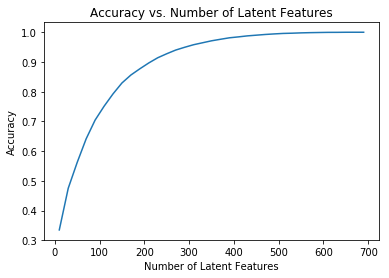

In [42]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [43]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    # Create user-item matrix for the training data
    user_item_train = df_train.groupby(['user_id', 'article_id']).size().unstack(fill_value=0)
    user_item_train = user_item_train.applymap(lambda x: 1 if x > 0 else 0)
    
    # Create user-item matrix for the testing data
    user_item_test = df_test.groupby(['user_id', 'article_id']).size().unstack(fill_value=0)
    user_item_test = user_item_test.applymap(lambda x: 1 if x > 0 else 0)
    
    # Extract all user ids from the test set
    test_idx = list(df_test['user_id'].unique())
    
    # Extract all article ids from the test set
    test_arts = list(df_test['article_id'].unique())
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [44]:
# How many users can we make predictions for in the test set?
users_in_both_sets = user_item_train.index.isin(test_idx)
users_can_predict = sum(users_in_both_sets)
print("How many users can we make predictions for in the test set?: ", users_can_predict)

# How many users are we not able to make predictions for because of the cold start problem?
users_cannot_predict = len(test_idx) - users_can_predict
print("How many users are we not able to make predictions for because of the cold start problem?: ", users_cannot_predict)

# How many articles can we make predictions for in the test set?
articles_in_both_sets = user_item_train.columns.isin(test_arts)
articles_can_predict = sum(articles_in_both_sets)
print("How many articles can we make predictions for in the test set?: ", articles_can_predict)

# How many articles are we not able to make predictions for because of the cold start problem?
articles_cannot_predict = len(test_arts) - articles_can_predict
print("How many articles are we not able to make predictions for because of the cold start problem?: ", articles_cannot_predict)

How many users can we make predictions for in the test set?:  20
How many users are we not able to make predictions for because of the cold start problem?:  662
How many articles can we make predictions for in the test set?:  574
How many articles are we not able to make predictions for because of the cold start problem?:  0


In [45]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [46]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train =np.linalg.svd(user_item_train, full_matrices=False) # fit svd similar to above then use the cells below

In [47]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [48]:
# Find test users and articles that are also in the training set
test_users_subset = np.intersect1d(user_item_test.index, user_item_train.index)
test_articles_subset = np.intersect1d(user_item_test.columns, user_item_train.columns)

# Create the test user-item matrix for users and articles that also exist in the training set
user_item_test_subset = user_item_test.loc[test_users_subset, test_articles_subset]

In [49]:
from sklearn.metrics import accuracy_score

num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.dot(np.dot(u_train_k, s_train_k), vt_train_k)
    
    # Get the subset of rows from the estimated matrix that matches the test set subset
    user_row_idxs = user_item_train.index.isin(test_users_subset)
    article_col_idxs = user_item_train.columns.isin(test_articles_subset)
    user_item_est_subset = user_item_est[user_row_idxs, :][:, article_col_idxs]
    
    # Calculate the error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset.values, user_item_est_subset)
    
    # Calculate the overall error
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    # Calculate accuracy
    preds_binary = user_item_est_subset.round()
    accuracy = accuracy_score(user_item_test_subset.values.flatten(), preds_binary.flatten())
    print(f"Latent Features: {k}, Accuracy: {accuracy:.4f}")

Latent Features: 10, Accuracy: 0.9784
Latent Features: 30, Accuracy: 0.9766
Latent Features: 50, Accuracy: 0.9753
Latent Features: 70, Accuracy: 0.9736
Latent Features: 90, Accuracy: 0.9723
Latent Features: 110, Accuracy: 0.9705
Latent Features: 130, Accuracy: 0.9695
Latent Features: 150, Accuracy: 0.9687
Latent Features: 170, Accuracy: 0.9680
Latent Features: 190, Accuracy: 0.9673
Latent Features: 210, Accuracy: 0.9666
Latent Features: 230, Accuracy: 0.9663
Latent Features: 250, Accuracy: 0.9658
Latent Features: 270, Accuracy: 0.9654
Latent Features: 290, Accuracy: 0.9652
Latent Features: 310, Accuracy: 0.9648
Latent Features: 330, Accuracy: 0.9648
Latent Features: 350, Accuracy: 0.9646
Latent Features: 370, Accuracy: 0.9646
Latent Features: 390, Accuracy: 0.9645
Latent Features: 410, Accuracy: 0.9645
Latent Features: 430, Accuracy: 0.9645
Latent Features: 450, Accuracy: 0.9645
Latent Features: 470, Accuracy: 0.9645
Latent Features: 490, Accuracy: 0.9645
Latent Features: 510, Accuracy

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

The results from the previous question show an interesting trend, as the number of latent features increases, the accuracy of predictions on the test data slightly decreases. This might seem counterintuitive initially, but it can be explained by the concept of overfitting. When the model uses more latent features, it becomes more tailored to the training data (hence possibly achieving higher accuracy there), but it may not generalize well to unseen data, leading to a decrease in test accuracy.

# Observations:
## High Baseline Accuracy: 
The accuracy starts very high (at 0.9784 for 10 latent features) and only slightly decreases as the number of latent features increases. This high baseline could be due to the sparsity of the user-item matrix where the majority of entries are zeros, meaning that predicting a non-interaction is often correct.

## Diminishing Returns on Adding Features: 
The incremental decrease in accuracy suggests diminishing returns on adding more latent features beyond a certain point. It indicates that a relatively small number of latent features are sufficient to capture the majority of the useful variance in the data.

# Recommendations for Evaluation:
Given these observations, determining the effectiveness of the recommendation systems (SVD-based or others) in improving user engagement with articles requires a more holistic evaluation approach beyond accuracy:

## A/B Testing: 
Implement A/B testing by exposing one group of users to recommendations generated by the SVD model and another group to a control version (e.g., random recommendations or no recommendations). Metrics such as click-through rates, time spent on recommended articles, or number of articles read could provide direct evidence of the system's effectiveness.

## Diversity and Novelty: 
Evaluate the diversity and novelty of the recommendations. A system that suggests a wide range of topics or uncovers less obvious articles might enhance user engagement by providing a more enriching experience.

## User Satisfaction Surveys: 
Collect user feedback on the relevance and usefulness of recommendations through surveys. User perceptions can offer valuable insights that raw performance metrics might not capture.

## Usage Metrics: 
Monitor changes in overall platform engagement metrics, such as daily active users or session length, after the introduction of the recommendation system. Improvements in these metrics could indicate a positive impact on user experience.

# Conclusion:
While the SVD-based recommendation system demonstrates high accuracy, optimizing the number of latent features is crucial to balance model complexity and generalizability. However, assessing the system's real-world effectiveness requires a broader set of evaluation strategies, including A/B testing and user feedback, to ensure that the recommendations meaningfully enhance the user experience. The aim is not just to make accurate predictions but to drive more meaningful interactions on the platform.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [50]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0